### Instructions for Running the Code
#### To run this analysis:
#### - Ensure all datasets ('calls.csv', 'sentiment.csv', 'reason.csv', 'customers.csv', 'test.csv') are available in the working directory.
#### - Execute the script in a Python environment with required packages installed (pandas, matplotlib, seaborn, sklearn, numpy).
#### - The output files and visualizations will provide insights on call center performance.

### Importing Necessary Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import re

### Load the Datasets

In [2]:
calls_df = pd.read_csv('/kaggle/input/predict12/callsf0d4f5a.csv')
sentiment_df = pd.read_csv('/kaggle/input/predict12/sentiment_statisticscc1e57a.csv')
reason_df = pd.read_csv('/kaggle/input/predict12/reason18315ff.csv')
customers_df = pd.read_csv('/kaggle/input/predict12/customers2afd6ea.csv')

## Convert Date Columns to Datetime Format

In [3]:
calls_df['call_start_datetime'] = pd.to_datetime(calls_df['call_start_datetime'])
calls_df['agent_assigned_datetime'] = pd.to_datetime(calls_df['agent_assigned_datetime'])
calls_df['call_end_datetime'] = pd.to_datetime(calls_df['call_end_datetime'])

### Calculate AHT (Average Handle Time) and AST (Average Speed to Answer) in seconds for each call

In [4]:
calls_df['handle_time_seconds'] = (calls_df['call_end_datetime'] - calls_df['agent_assigned_datetime']).dt.total_seconds()

calls_df['speed_to_answer_seconds'] = (calls_df['agent_assigned_datetime'] - calls_df['call_start_datetime']).dt.total_seconds()

### Merge Calls Dataset with Sentiment, Reason, and Customers datasets

In [5]:
merged_df = calls_df.merge(sentiment_df, on=['call_id'], how='outer') \
                    .merge(reason_df, on='call_id', how='outer') \
                    .merge(customers_df, on='customer_id', how='outer')

### Handling Missing Values

In [6]:
columns_to_impute = ['handle_time_seconds', 'speed_to_answer_seconds', 'average_sentiment', 'silence_percent_average']
columns_to_impute = [col for col in columns_to_impute if col in merged_df.columns]

imputer = SimpleImputer(strategy='mean')
merged_df[columns_to_impute] = imputer.fit_transform(merged_df[columns_to_impute])

# Handle missing values for elite_level_code
if 'elite_level_code' in merged_df.columns:
    merged_df['elite_level_code'] = merged_df['elite_level_code'].fillna(0)

### Set Customer Weight

In [7]:
if 'elite_level_code' in merged_df.columns:
    merged_df['customer_weight'] = merged_df['elite_level_code']
else:
    merged_df['customer_weight'] = 1  # Default weight if elite_level_code is missing


### Prepare Features for Clustering

In [8]:
relevant_features = ['handle_time_seconds', 'speed_to_answer_seconds', 'average_sentiment', 'silence_percent_average', 'customer_weight', 'agent_experience_level']
relevant_features = [feature for feature in relevant_features if feature in merged_df.columns]

clustering_features = merged_df[relevant_features].dropna()

# Convert categorical features to numeric using one-hot encoding if they exist
if 'agent_experience_level' in clustering_features.columns:
    clustering_features = pd.get_dummies(clustering_features, columns=['agent_experience_level'])

# Standardize the features to give equal importance
scaler = StandardScaler()
clustering_features_scaled = scaler.fit_transform(clustering_features)

### Apply K-Means Clustering

In [9]:
kmeans = KMeans(n_clusters=3, random_state=42)
merged_df['cluster'] = kmeans.fit_predict(clustering_features_scaled)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


### Display Basic Statistics for AHT and AST

In [10]:
aht_stats = merged_df['handle_time_seconds'].describe()
ast_stats = merged_df['speed_to_answer_seconds'].describe()

print("AHT Statistics:")
print(aht_stats)
print("\nAST Statistics:")
print(ast_stats)


AHT Statistics:
count    71810.000000
mean       697.048600
std        774.301509
min          0.000000
25%        240.000000
50%        420.000000
75%        900.000000
max       7140.000000
Name: handle_time_seconds, dtype: float64

AST Statistics:
count    71810.000000
mean       437.067539
std        151.129771
min        180.000000
25%        300.000000
50%        420.000000
75%        540.000000
max        900.000000
Name: speed_to_answer_seconds, dtype: float64


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


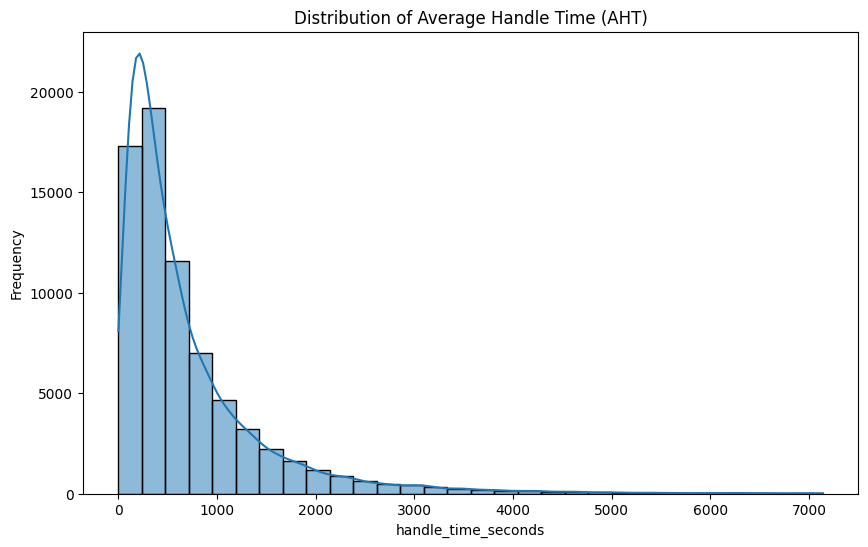

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


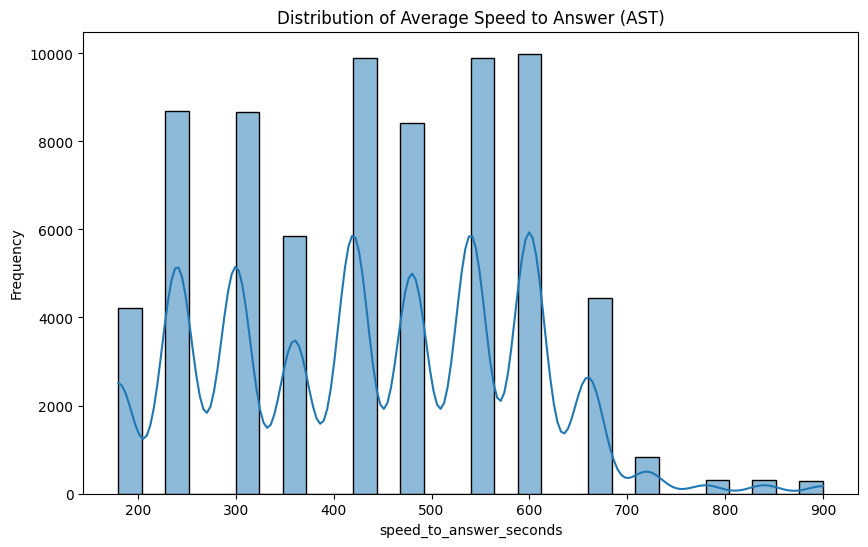

In [11]:
def plot_metric_distribution(data, metric, title):
    plt.figure(figsize=(10, 6))
    sns.histplot(data[metric], kde=True, bins=30)
    plt.title(title)
    plt.xlabel(metric)
    plt.ylabel('Frequency')
    plt.show()  # Show plot in Jupyter Notebook

# Example usage
plot_metric_distribution(merged_df, 'handle_time_seconds', 'Distribution of Average Handle Time (AHT)')
plot_metric_distribution(merged_df, 'speed_to_answer_seconds', 'Distribution of Average Speed to Answer (AST)')

### Identify Top Reasons Contributing to High AHT

### Optimize IVR Routing Based on Frequent Transfer Reasons

In [14]:
if 'primary_call_reason' in merged_df.columns:
    transfer_analysis = merged_df.groupby('primary_call_reason')['speed_to_answer_seconds'].mean().sort_values(ascending=False).head(5)
    print("\nTop 5 Call Reasons with Long AST (Optimization Opportunities for IVR):")
    print(transfer_analysis)

    # Save long AST reasons to CSV for IVR optimization reference
    transfer_analysis.to_csv('long_ast_reasons.csv', index=True)


Top 5 Call Reasons with Long AST (Optimization Opportunities for IVR):
primary_call_reason
Checkout                 725.021739
Unaccompanied Minor      720.000000
Checkout                 712.500000
Traveler  Updates        691.578947
Traveler Updates         690.466321
Name: speed_to_answer_seconds, dtype: float64


In [15]:
if 'primary_call_reason' in merged_df.columns:
    high_aht_reasons = merged_df.groupby('primary_call_reason')['handle_time_seconds'].mean().sort_values(ascending=False).head(5)
    print("\nTop 5 Reasons Contributing to High AHT:")
    print(high_aht_reasons)

    # Further analysis on reasons contributing to high AHT
    for reason in high_aht_reasons.index:
        subset = merged_df[merged_df['primary_call_reason'] == reason]
        avg_sentiment = subset['average_sentiment'].mean() 
        avg_ast = subset['speed_to_answer_seconds'].mean()
        avg_silence = subset['silence_percent_average'].mean() if 'silence_percent_average' in subset.columns else 'N/A'
        print(f"\nFurther Analysis for Reason: {reason}")
        print(f"Average Sentiment Score: {avg_sentiment:.2f}")
        print(f"Average Speed to Answer (AST): {avg_ast:.2f} seconds")
        print(f"Average Silence Percentage: {avg_silence:.2f}%" if avg_silence != 'N/A' else f"Average Silence Percentage: {avg_silence}")

    # Save high AHT reasons to CSV for training reference
    high_aht_reasons.to_csv('high_aht_reasons.csv', index=True)



Top 5 Reasons Contributing to High AHT:
primary_call_reason
ETC              1600.909091
Checkout         1342.500000
Mileage  Plus    1019.555556
Checkout         1008.358696
Mileage Plus      995.724440
Name: handle_time_seconds, dtype: float64

Further Analysis for Reason: ETC  
Average Sentiment Score: -0.06
Average Speed to Answer (AST): 518.18 seconds
Average Silence Percentage: 0.31%

Further Analysis for Reason: Checkout  
Average Sentiment Score: -0.07
Average Speed to Answer (AST): 712.50 seconds
Average Silence Percentage: 0.35%

Further Analysis for Reason: Mileage  Plus
Average Sentiment Score: -0.03
Average Speed to Answer (AST): 351.56 seconds
Average Silence Percentage: 0.27%

Further Analysis for Reason: Checkout
Average Sentiment Score: -0.07
Average Speed to Answer (AST): 725.02 seconds
Average Silence Percentage: 0.29%

Further Analysis for Reason: Mileage Plus
Average Sentiment Score: -0.03
Average Speed to Answer (AST): 361.22 seconds
Average Silence Percentage: 

### Visualize Clustering Results

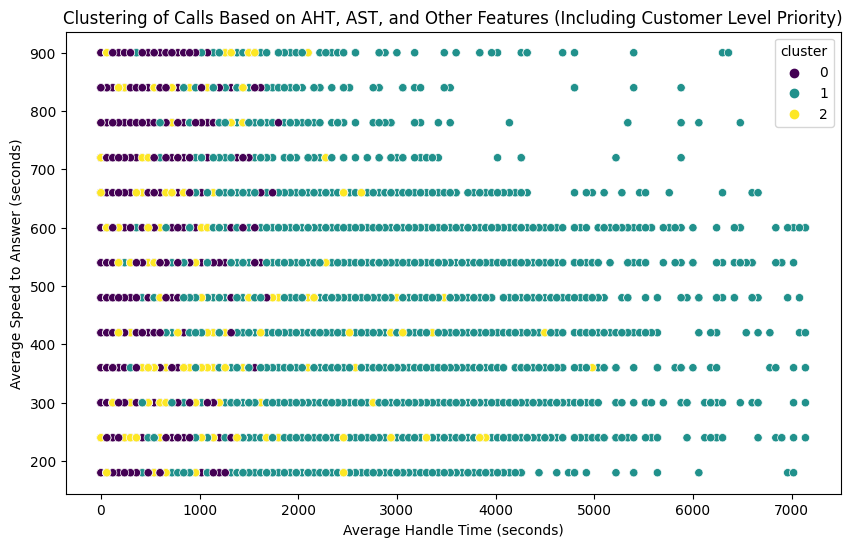


Cluster Centers:
[[-0.39771565  0.05522895  0.02835885 -0.46969561 -0.49660626]
 [ 1.00364852 -0.06566674 -0.08233332  1.19609647 -0.26576012]
 [-0.18384178 -0.06416429  0.02621354 -0.23026191  1.61890363]]


In [16]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='handle_time_seconds', y='speed_to_answer_seconds', hue='cluster', data=merged_df, palette='viridis')
plt.title('Clustering of Calls Based on AHT, AST, and Other Features (Including Customer Level Priority)')
plt.xlabel('Average Handle Time (seconds)')
plt.ylabel('Average Speed to Answer (seconds)')
plt.show()

print("\nCluster Centers:")
print(kmeans.cluster_centers_)


### Sentiment Trend Analysis Over Time

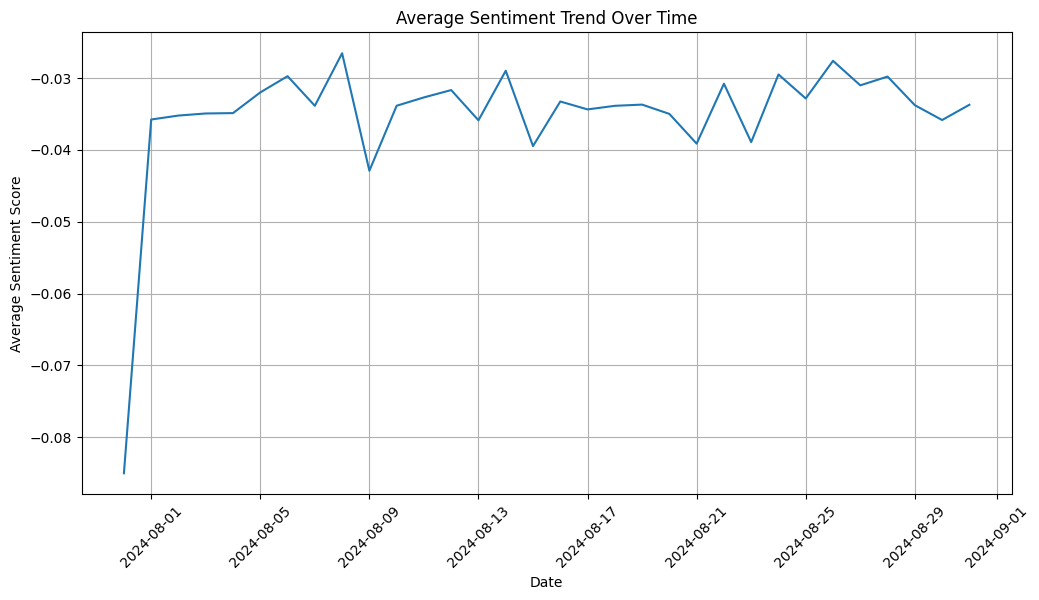


Sentiment Trend Analysis Over Time:
count    32.000000
mean     -0.035208
std       0.009735
min      -0.085000
25%      -0.035361
50%      -0.033819
75%      -0.031514
max      -0.026555
Name: average_sentiment, dtype: float64


In [17]:
if 'call_start_datetime' in merged_df.columns and 'average_sentiment' in merged_df.columns:
    merged_df['call_date'] = merged_df['call_start_datetime'].dt.date
    daily_sentiment_trend = merged_df.groupby('call_date')['average_sentiment'].mean()
    
    plt.figure(figsize=(12, 6))
    daily_sentiment_trend.plot()
    plt.title('Average Sentiment Trend Over Time')
    plt.xlabel('Date')
    plt.ylabel('Average Sentiment Score')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

    print("\nSentiment Trend Analysis Over Time:")
    print(daily_sentiment_trend.describe())

    # Generate alerts for declining sentiment trends
    if daily_sentiment_trend.min() < -0.5:
        print("\nAlert: Significant decline in sentiment detected. Immediate action recommended.")


### Identify Self-Solvable Issues

In [18]:
def identify_self_solvable_issues(df):
    # Analyze frequently occurring words in call transcripts
    if 'call_transcript' in df.columns:
        vectorizer = CountVectorizer(stop_words='english')
        X = vectorizer.fit_transform(df['call_transcript'])
        word_freq = pd.DataFrame({'word': vectorizer.get_feature_names_out(), 'frequency': X.sum(axis=0).A1})
        word_freq = word_freq.sort_values('frequency', ascending=False)
        
        print("\nTop 20 frequently occurring words in call transcripts:")
        print(word_freq.head(20))
        
        # Generate word cloud
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq.set_index('word')['frequency'])
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title('Word Cloud of Call Transcripts')
        plt.savefig('call_transcript_wordcloud.png')
        plt.close()
    
    # Analyze call reasons
    if 'primary_call_reason' in df.columns:
        reason_counts = df['primary_call_reason'].value_counts()
        print("\nTop 10 call reasons:")
        print(reason_counts.head(10))
        
        # Identify potential self-solvable issues
        low_complexity_reasons = reason_counts[reason_counts.index.str.contains('info|update|check|status', case=False, regex=True)]
        print("\nPotential self-solvable issues:")
        print(low_complexity_reasons)

    # Save potential self-solvable issues to CSV
    low_complexity_reasons.to_csv('self_solvable_issues.csv', index=True)

identify_self_solvable_issues(merged_df)


Top 20 frequently occurring words in call transcripts:
           word  frequency
16078    flight     631962
7048      agent     555458
13456  customer     549932
21734       let     310728
12446    change     248693
18418      help     201067
21804      like     194177
28767     thank     184727
30949    united     173306
12218   calling     159962
23160      okay     156940
29312    typing     155719
21135      just     135322
31655      work     134236
13745       day     133868
28921      time     127528
22849      need     126268
33432      yeah     123142
25811    really     119979
28772    thanks     119782

Top 10 call reasons:
primary_call_reason
IRROPS                   13057
Voluntary Change         10291
Seating                   6223
Mileage Plus              5487
Post-Flight               3869
Communications            3779
Products and Services     2792
Upgrade                   2682
Baggage                   2616
Booking                   2589
Name: count, dtype: int64